<a href="https://colab.research.google.com/github/yoheikikuta/US-patent-analysis/blob/master/colab/bert_tripletloss_with_hardest_example_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab porting of triplet loss  with hard example mining trial for bert feature

OVERALL RESULTS:

Hard example mining makes tripleloss model better.  
The result of the hardest example mining is a bit better than that of train_on_difficulty result in [this notebook](https://github.com/yoheikikuta/US-patent-analysis/blob/master/colab/bert_tripletloss.ipynb).  
Euclidean distance and cossine distance shows no significant difference.

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np

import tensorflow as tf

tf.enable_eager_execution()

In [0]:
tf.__version__

In [0]:
!git clone -b docker https://github.com/yoheikikuta/bert.git

In [3]:
!ls

adc.json  bert	sample_data


# Data setup

Feature data is created at bert-extract-feature.ipynb.

In [0]:
os.makedirs("./bert/data", exist_ok=True)

In [0]:
# LOSS FUNCTIONS

# EUCLIDEAN DISTANCE
# def dist(a, b):
#     with tf.name_scope('dist'):
#         # assuming that 'a' has dimensions 18 x 100 and 'b' has dimensions 
#         # 34x100, we would like to produce a vector with all distances,
#         # having the shape 18 x 34.
#         # we hence first cast 'a' to a shape 18 x 1 x 100
#         # and then 'b' to a shape 1 x 34 x 100. 
#         # rules of broadcasting then give us a tensor of 18 x 34 x 100
#         # summing over the last axis only (axis=-1) gives us the desired
#         # 18 x 34 shape
#         diffs = tf.expand_dims(a, axis=1) - tf.expand_dims(b, axis=0)
#         return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1) + 1e-12)

# COSINE DISTANCE
def dist(a, b):
    with tf.name_scope('dist'):
        prods = tf.math.multiply(tf.expand_dims(a, axis=1), tf.expand_dims(b, axis=0))
        unnormalized_dist = tf.subtract(tf.constant(1.0, dtype=tf.float32),
                                        tf.reduce_sum(prods, axis=-1))
        normalized_dist = tf.multiply(unnormalized_dist, 0.5)
        return normalized_dist + 1e-12

def calc_cited_mask(data_dict):
    aids_one_hot = tf.equal(tf.expand_dims(data_dict['app_ids_u'], axis=1),
                            tf.expand_dims(data_dict['app_ids'], axis=0))
    gids_one_hot = tf.equal(tf.expand_dims(data_dict['grant_ids'], axis=1),
                            tf.expand_dims(data_dict['grant_ids_u'], axis=0))
    cited_mask = tf.matmul(tf.cast(aids_one_hot, tf.int32), 
                           tf.cast(gids_one_hot, tf.int32))
    cited_mask = tf.equal(cited_mask, 1)
    return cited_mask
  
def batch_hard(dists, cited_mask, margin=0.2):
    # Assume that app_ids_unique has shape (18, ) and grant_ids_unique (34,)
    # app_ids and grant_ids have the same length, 36. This implies 
    # that there are 2 grants that appear twice.
    # We construct a mask for same identity of shape 18 x 34
    negative_mask = tf.logical_not(cited_mask)
    positive_mask = cited_mask
    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32),
                                      axis=1)
    closest_negative = tf.map_fn(lambda x:tf.reduce_min(
                                 tf.boolean_mask(x[0], x[1])),
                                 (dists, negative_mask), tf.float32)
    diff = furthest_positive - closest_negative
    diff = tf.maximum(diff + margin, 0.0)
    return diff
  
def calc_ranks(rdists, cited_mask):
    _, indices = tf.nn.top_k(-rdists, k=rdists.shape[1])
    _, indices = tf.nn.top_k(-indices, k=rdists.shape[1])
    indices = indices +1
    sorted_ranks = tf.sort(tf.reshape(tf.cast(cited_mask, tf.int32) * indices, 
                                      [-1]))
    unique, vals, counts = tf.unique_with_counts(sorted_ranks)
    return dict(zip(unique.numpy(), counts.numpy()))
  

In [0]:
class Model(object):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.W = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ), name='weight' )
        self.B = tf.Variable( tf.random_normal( [self.output_shape] ), name='bias' ) 
        self.variables = [ self.W, self.B ]
    
    def frwrd_pass(self,X_train):
        out = tf.matmul( X_train, self.W ) + self.B
        normalized_out = tf.nn.l2_normalize(out, axis=1)
        return normalized_out

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil cp gs://karino2-uspatent/features/training_app_1000_features.pkl.gz bert/data/training_app_1000_features.pkl.gz
!gsutil cp gs://karino2-uspatent/features/test_app_1000_features.pkl.gz bert/data/test_app_1000_features.pkl.gz
!gsutil cp gs://karino2-uspatent/features/grants_2000_features.pkl.gz bert/data/grants_2000_features.pkl.gz

In [8]:
with gzip.open("./bert/data/training_app_1000_features.pkl.gz", 'rb') as f:
     train_features = pickle.load(f)
with gzip.open("./bert/data/test_app_1000_features.pkl.gz", 'rb') as f:
     test_features = pickle.load(f)
with gzip.open("./bert/data/grants_2000_features.pkl.gz", 'rb') as f:
     grants_features = pickle.load(f)
print(f"{train_features.shape}, {test_features.shape}, {grants_features.shape}")

(1000, 768), (1000, 768), (2524, 768)


In [0]:
!gsutil cp gs://karino2-uspatent/citations_info_2000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/testset_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/training_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/grants_for_2000.df.gz ./bert/data/

In [0]:
citations_info_target = pd.read_pickle("./bert/data/citations_info_2000.df.gz")
train_app_df = pd.read_pickle("./bert/data/training_app_1000.df.gz")
test_app_df = pd.read_pickle("./bert/data/testset_app_1000.df.gz")
grants_target_df = pd.read_pickle("./bert/data/grants_for_2000.df.gz")

In [0]:
pd.set_option('display.max_columns', 50)

In [11]:
citations_info_target.parsed.unique().shape

(2524,)

### Prepare data for circulum tripletloss learning

In [0]:
import random
import pandas as pd
import numpy as np
import pickle
from collections import OrderedDict

In [0]:
train_normalized_feature_dict_1000 = { 
    k:v/np.linalg.norm(v) for k,v in zip(train_app_df['app_id'], train_features[:, ])
}

grants_normalized_feature_dict_2000 = { 
    
    k:v/np.linalg.norm(v) for k,v in zip(grants_target_df['parsed'], grants_features[:, ])
}

test_normalized_feature_dict_1000 = { 
    k:v/np.linalg.norm(v) for k,v in zip(test_app_df['app_id'], test_features[:, ])
}

In [0]:
train_apps_df = pd.DataFrame.from_dict(train_normalized_feature_dict_1000).T
grants_target_df = pd.DataFrame.from_dict(grants_normalized_feature_dict_2000).T
test_apps_df = pd.DataFrame.from_dict(test_normalized_feature_dict_1000).T

In [0]:
def make_dict_from_chunk(df):
    app_ids_u = df.index.values
    cited_df = citations_info_target.loc[:, ['app_id', 'parsed']]\
                   .drop_duplicates().set_index('app_id')\
                   .loc[app_ids_u, ['parsed']].reset_index()
    app_ids = cited_df.app_id.values
    grant_ids = cited_df.parsed.values
    grant_ids_u = cited_df.parsed.unique()
    app_ids_u_blob = df.reindex(app_ids_u).values
    grant_ids_u_blob = grants_target_df.reindex(grant_ids_u).values
    data_dict = {'app_ids_u':app_ids_u, 'app_ids':app_ids, 
                 'app_ids_u_blob': app_ids_u_blob,
                 
                 'grant_ids_u':grant_ids_u, 'grant_ids':grant_ids,
                 'grant_ids_u_blob':grant_ids_u_blob}
    return data_dict

def get_batch(b_size=20, df=train_apps_df):
    df = df.sample(frac=1)
    for chunk in np.array_split(df, b_size):
        yield make_dict_from_chunk(chunk)

In [0]:
from tqdm import tqdm_notebook as tqdm

In [17]:
loss_history = []
model_apps = Model(input_shape=768, output_shape=100)
model = Model(input_shape=768, output_shape=100)
EPOCHS = 30
BATCH_SIZE = 20

dev_data_dict = make_dict_from_chunk(test_apps_df.iloc[:200])
train_check_data_dict = make_dict_from_chunk(train_apps_df.iloc[:100])

def calc_dists_for_model(dd, model):
  app_ids_u_emb = model.frwrd_pass(dd['app_ids_u_blob'].astype('float32'))
  grant_ids_u_emb = model.frwrd_pass(dd['grant_ids_u_blob'].astype('float32'))
  dists = dist(app_ids_u_emb, grant_ids_u_emb)
  return dists

for i in tqdm(range(EPOCHS)):
  for data_dict in get_batch():
    #data_dict = train_check_data_dict
    with tf.GradientTape() as tape:
        dists = calc_dists_for_model(data_dict, model)
        cited_mask = calc_cited_mask(data_dict)
        losses = batch_hard(dists, cited_mask)
        loss = tf.reduce_mean(losses)
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)
  
  #after every epoch, we would like to check our ranking score on the dev_data_dict,
  #as well as on some subset of our training data dict
  dev_dists = calc_dists_for_model(dev_data_dict, model)
  dev_cited_mask = calc_cited_mask(dev_data_dict)
  dev_ranks = calc_ranks(dev_dists, dev_cited_mask)
  top_5_ranks = sum(list(dev_ranks.values())[1:6])/200.0
  top_1_rank = list(dev_ranks.values())[1]/200.0
  print('Top 5 ranks (%): ' + str(top_5_ranks) + ', ' + 'Top 1 rank (%): '+str(top_1_rank))
  #train_dists = calc_dists_for_model(train_check_data_dict, model)
  #cited_mask = calc_cited_mask(train_check_data_dict)
  #train_ranks = calc_ranks(train_dists, cited_mask)
  #print(train_ranks)
  #print(loss.numpy())
  #print(tf.cast(cited_mask, tf.int32).numpy())
  #print(train_dists)
  #print(dev_ranks)
  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Top 5 ranks (%): 0.79, Top 1 rank (%): 0.41
Top 5 ranks (%): 0.8, Top 1 rank (%): 0.45
Top 5 ranks (%): 0.84, Top 1 rank (%): 0.485
Top 5 ranks (%): 0.865, Top 1 rank (%): 0.49
Top 5 ranks (%): 0.89, Top 1 rank (%): 0.49
Top 5 ranks (%): 0.9, Top 1 rank (%): 0.505
Top 5 ranks (%): 0.89, Top 1 rank (%): 0.505
Top 5 ranks (%): 0.915, Top 1 rank (%): 0.495
Top 5 ranks (%): 0.905, Top 1 rank (%): 0.495
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.475
Top 5 ranks (%): 0.92, Top 1 rank (%): 0.52
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.5
Top 5 ranks (%): 0.915, Top 1 rank (%): 0.515
Top 5 ranks (%): 0.935, Top 1 rank (%): 0.51
Top 5 ranks (%): 0.9, Top 1 rank (%): 0.49
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.495
Top 5 ranks (%): 0.905, Top 1 rank (%): 0.5
Top 5 ranks (%): 0.905, Top 1 rank (%): 0.

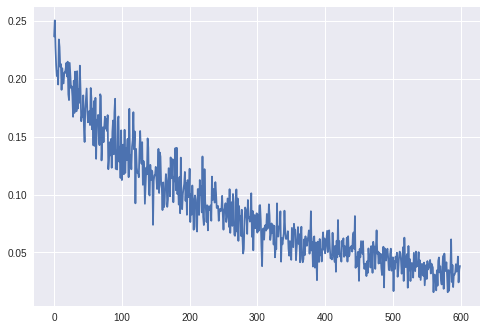

In [21]:
# from matplotlib import pyplot as plt 
# plt.plot(loss_history)

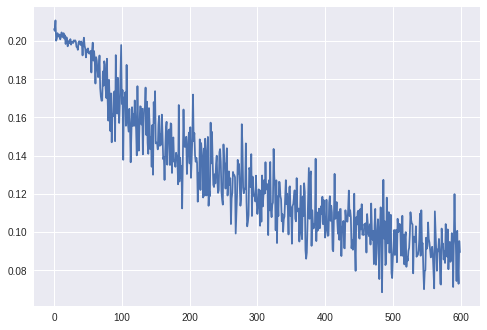

In [18]:
## Result of cosine distance
from matplotlib import pyplot as plt 
plt.plot(loss_history)

### Calculate cosin similarity for whole pair

In [19]:
%%time

sim_dict = {
    app_id:{ parsed:np.sum(train_normalized_feature_dict_1000[app_id]*grants_normalized_feature_dict_2000[parsed])
            for parsed 
            in grants_target_df.index } 
    for app_id 
    in train_app_df['app_id']
}

CPU times: user 14.3 s, sys: 110 ms, total: 14.4 s
Wall time: 14.4 s


check result

### Create triplet

### Train Model

### Inferece with trained model

Saver seems fragile in eager mode. I use trained model on memory.

In [0]:
test_normalized_feature_dict_1000 = { 
    k:v/np.linalg.norm(v) for k,v in zip(test_app_df['app_id'], test_features[:, ])
}

In [0]:
def to_extracted_features(normalized_feature_dict, model):
  # doc_id is app_id for application, pared for grants.
  sorted_keys = sorted(normalized_feature_dict.keys())

  input_tensors = tf.convert_to_tensor(
      np.array([ normalized_feature_dict[k] for k in sorted_keys ]),
      dtype=tf.float32)
  extracted_features = model.frwrd_pass(input_tensors).numpy()
  return pd.DataFrame({ 
    'doc_id':sorted_keys, 'extracted_feature':[ v/np.linalg.norm(v) for v in extracted_features ]})

In [0]:
def sort_similarity_by_value(sim_dict, app_id):
    '''
    input:
        sim_dict: similary dictionary
        app_id: target application id
    return:
        [(parsed1, sim1), (parsed2, sim2), ...] sorted by similarities
    '''
    return [(parsed, sim_dict[app_id][parsed]) for parsed in sorted(sim_dict[app_id], key=sim_dict[app_id].get)]
  
  
def get_cited_grants(citations_info_target, app_id):
    '''
    input:
        citations_info_target: DataFrame of citation relationships
        app_id: target application id
    return:
        {parsed1, parsed2, ...} that are cited to reject app_id
    '''
    return set(citations_info_target[citations_info_target['app_id'] == app_id]['parsed'])
  
def make_uncited_grants_for_app_id(sim_dict, citations_info_target, app_id, sidx, eidx, num, shuffle=True):
    '''
    input:
        sim_dict: 
        citations_info_target:
        app_id: target application id
        sidx: start index to slice the sorted (parsed, sim) list
        eidx: end index to slice the sorted (parsed, sim) list
        num: number of grants that will be returned
    return:
        [parsed_1, parsed_2, ..., parsed_num] that are NOT cited to reject app_id
    '''
    sorted_grants_list = sort_similarity_by_value(sim_dict, app_id)
    sorted_grants_list = sorted_grants_list[sidx:eidx]
    if shuffle:
        random.shuffle(sorted_grants_list)
    
    cited_grants = get_cited_grants(citations_info_target, app_id)
    uncited_grants = []
    
    idx = 0
    while len(uncited_grants) != num:
        grant_id, _ = sorted_grants_list[idx]
        if not grant_id in cited_grants:
            uncited_grants.append(grant_id)
        idx += 1
    
    return uncited_grants  

In [0]:
import collections

def calc_all_ranks(all_app_ids, sim_dic):
  all_ranks = []

  for app_id in all_app_ids:
      cited_grants = get_cited_grants(citations_info_target, app_id)
      sorted_kv = reversed(sort_similarity_by_value(sim_dic, app_id))  # higher score, similar patent

      idx = 1
      for k,v in sorted_kv:
          if k in cited_grants:
              all_ranks.append(idx)
          idx += 1
  return all_ranks

def calc_all_ranks_counter(all_app_ids, sim_dic):
  return collections.Counter(calc_all_ranks(all_app_ids, sim_dic))

In [0]:
test_extracted_features_df = to_extracted_features(test_normalized_feature_dict_1000, model)
grants_extracted_features_df = to_extracted_features(grants_normalized_feature_dict_2000, model)

In [25]:
test_extracted_features_df.head(2)

,doc_id,extracted_feature
0,12000862,"[-0.06151366, 0.11195387, 0.036500394, 0.08173..."
1,12003258,"[-0.08109531, -0.12255129, 0.042114027, -0.009..."


In [26]:
grants_extracted_features_df.head(2)

,doc_id,extracted_feature
0,6837383,"[0.028771035, -0.18207307, -0.018155547, -0.04..."
1,6837647,"[-0.0036089611, -0.015606154, 0.09980473, 0.17..."


In [0]:
def create_sim_dict(test_extracted_df, grants_extracted_df):
  return {
    app_id:{ parsed:np.sum(test_f*grants_f)
            for parsed, grants_f 
            in zip(grants_extracted_df['doc_id'], grants_extracted_df['extracted_feature']) } 
    for app_id, test_f 
    in zip(test_extracted_df['doc_id'], test_extracted_df['extracted_feature'])
  }

In [32]:
# %%time
# test_extracted_features_df = to_extracted_features(test_normalized_feature_dict_1000, model)
# grants_extracted_features_df = to_extracted_features(grants_normalized_feature_dict_2000, model)

# sim_dict_by_extracted = create_sim_dict(test_extracted_features_df, grants_extracted_features_df)
# counter = calc_all_ranks_counter(test_extracted_features_df['doc_id'], sim_dict_by_extracted)
# print(counter)

Counter({1: 208, 2: 90, 3: 61, 4: 54, 5: 39, 6: 33, 8: 32, 7: 23, 9: 20, 10: 17, 19: 16, 22: 15, 15: 15, 13: 14, 23: 13, 14: 13, 17: 12, 11: 12, 12: 11, 20: 10, 16: 10, 29: 9, 18: 9, 39: 9, 21: 9, 36: 9, 37: 8, 25: 8, 38: 7, 32: 7, 28: 7, 57: 6, 43: 5, 30: 5, 84: 5, 53: 5, 77: 5, 40: 5, 44: 5, 48: 5, 27: 5, 26: 5, 54: 4, 89: 4, 73: 4, 34: 4, 33: 4, 45: 4, 24: 4, 60: 4, 74: 4, 103: 4, 47: 4, 52: 4, 61: 4, 92: 3, 79: 3, 118: 3, 62: 3, 107: 3, 145: 3, 35: 3, 85: 3, 351: 3, 156: 3, 187: 3, 135: 3, 113: 3, 63: 3, 46: 3, 66: 3, 88: 3, 50: 3, 93: 3, 31: 3, 111: 3, 99: 2, 90: 2, 256: 2, 59: 2, 68: 2, 218: 2, 58: 2, 109: 2, 304: 2, 115: 2, 86: 2, 96: 2, 143: 2, 459: 2, 97: 2, 119: 2, 55: 2, 150: 2, 464: 2, 433: 2, 172: 2, 116: 2, 301: 2, 56: 2, 125: 2, 70: 2, 120: 2, 226: 2, 82: 2, 114: 2, 158: 2, 191: 2, 138: 2, 170: 2, 42: 2, 276: 2, 266: 2, 380: 2, 102: 2, 67: 2, 117: 2, 140: 2, 161: 2, 300: 2, 177: 2, 155: 2, 134: 2, 133: 2, 449: 2, 724: 1, 163: 1, 205: 1, 2066: 1, 237: 1, 930: 1, 356: 1, 8

In [28]:
## Result of cosine distance
%%time
test_extracted_features_df = to_extracted_features(test_normalized_feature_dict_1000, model)
grants_extracted_features_df = to_extracted_features(grants_normalized_feature_dict_2000, model)

sim_dict_by_extracted = create_sim_dict(test_extracted_features_df, grants_extracted_features_df)
counter = calc_all_ranks_counter(test_extracted_features_df['doc_id'], sim_dict_by_extracted)
print(counter)

Counter({1: 216, 2: 85, 3: 55, 5: 47, 4: 46, 6: 34, 7: 30, 10: 24, 13: 24, 8: 23, 9: 22, 12: 20, 11: 17, 15: 14, 18: 12, 20: 11, 16: 11, 14: 10, 22: 10, 17: 9, 21: 9, 25: 8, 28: 8, 26: 8, 19: 8, 34: 7, 27: 7, 70: 7, 30: 7, 51: 6, 49: 6, 38: 6, 29: 6, 62: 6, 43: 5, 63: 5, 113: 5, 41: 5, 23: 5, 31: 5, 52: 5, 60: 5, 91: 4, 40: 4, 24: 4, 76: 4, 37: 4, 33: 4, 39: 4, 42: 4, 32: 4, 56: 4, 92: 4, 69: 3, 35: 3, 50: 3, 68: 3, 77: 3, 48: 3, 54: 3, 117: 3, 104: 3, 119: 3, 144: 3, 109: 3, 81: 3, 46: 3, 36: 3, 87: 3, 118: 3, 153: 3, 290: 3, 90: 3, 97: 3, 500: 3, 80: 3, 131: 3, 53: 3, 45: 2, 100: 2, 423: 2, 116: 2, 495: 2, 78: 2, 175: 2, 285: 2, 236: 2, 106: 2, 509: 2, 219: 2, 178: 2, 245: 2, 137: 2, 189: 2, 436: 2, 460: 2, 292: 2, 216: 2, 79: 2, 61: 2, 73: 2, 167: 2, 86: 2, 108: 2, 156: 2, 99: 2, 57: 2, 65: 2, 94: 2, 66: 2, 164: 2, 122: 2, 123: 2, 268: 2, 344: 2, 55: 2, 235: 2, 112: 2, 72: 2, 93: 2, 96: 2, 1318: 1, 194: 1, 537: 1, 480: 1, 2003: 1, 229: 1, 524: 1, 173: 1, 299: 1, 433: 1, 747: 1, 426:

For comaprison, remeber the result of using raw feature case.

```
Counter({1: 178, 2: 73, 3: 46, 5: 40, 4: 38, 6: 31, 7: 19, 9: 17, 8: 16, 10: 15, 13: 13, 14: 13, 11: 13, 15: 12, 18: 12, ...}
```